> ## Table of contents:

+ Loading packages

+ Loading data

1. Pre-processing

+ 1.1 Data Cleaning

    + Drop irrelevant columns

    + Handle missing values

    + Handle duplicated values

+ 1.2 Spliting Data

+ 1.3 Data Transforming

    + Handle invalid data

    + Handle outliers

    + Encode variables

    + Data normalization

2. Feature Selection & Data Sampling

3. Model Training

    + Hyperparameter tuning 

    + Compare different models' AUC

4. Model Evaluation

    + Economic modeling

    + Decision baselines

    + ROC-AUC curve, precision-recall curve, confufion matrix of best model

> ## Loading packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

> ## Loading Data

In [4]:
df = pd.read_csv('../data/cell2celltrain.csv')
df.sample(5)

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
28549,3226606,Yes,22.27,14.0,29.0,0.00,1.0,0.0,11.0,-0.3,...,0,6,No,0,Unknown,No,4-Medium,Town,Professional,Yes
44928,3355630,No,39.69,193.0,33.0,0.99,14.0,0.0,-23.0,-4.7,...,0,9,No,0,Unknown,No,1-Highest,Other,Professional,Yes
34544,3275594,Yes,55.55,482.0,40.0,0.00,72.0,0.4,14.0,6.3,...,0,0,No,0,Unknown,No,2-High,Rural,Other,Unknown
17720,3138714,No,73.91,613.0,70.0,0.00,44.0,0.6,-141.0,-13.9,...,0,8,No,0,80,No,2-High,Town,Other,Yes
43383,3344326,No,20.69,8.0,20.0,0.00,2.0,0.0,-4.0,-0.7,...,0,7,No,0,Unknown,No,2-High,Town,Professional,Yes


> ## 1. Pre-processing

 ### 1.1. Data cleaning

 #### Droping irrelevant columns
+ ```CustomerID```

+ ```ServiceArea```

In [5]:
df = df.drop(columns=['CustomerID', 'ServiceArea'])

#### Handle missing values
+ The dataset has 1271 rows where there is at least one missing value. This represents ```2.49%``` of the whole dataset. 

+ At this low percentage, the risk of introducing bias through imputation is higher than the risk of losing information by dropping. 

+ ***Therefore, the rows with missing data are dropped from the dataset***


In [6]:
na_row_pct = df.isna().any(axis = 1).sum() / df.shape[0] * 100
print(f"Total number of rows: {df.shape[0]}")
print(f"Number of rows with missing value: {df.isna().any(axis = 1).sum()}")
print(f"Percentage of rows with missing value: {na_row_pct:.2f}%")

Total number of rows: 51047
Number of rows with missing value: 1271
Percentage of rows with missing value: 2.49%


In [7]:
df = df.dropna()

#### Handle duplicated values

+ It appears there is no duplicated value in this dataset

In [8]:
df.duplicated().sum()

np.int64(0)

### 1.2 Splitting Data

+ The dataset is split into a train set (for cross-validation and fitting ML model) and a test set (to evaluate model performance) with the ratio ```85/15```

+ ```Handing data leakage```: Data splitting is performed before any subsequent data transformation step to prevent data leakage. All subsequent preprocessing steps — including imputation, winsorization (outlier capping), normalization, and encoding - were fit on the training set only. The learned parameters (e.g., medians, clipping thresholds, scaling ranges) are then applied to the validation and test sets

+ **Target feature** (churn) is converted to 1 and 0

In [9]:
X, y = df.drop(columns=['Churn']), df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=10, stratify=y)

y_train = y_train.map({'No': 0, 'Yes': 1})
y_test = y_test.map({'No': 0, 'Yes': 1})

print(f"Training set size: {X_train.shape[0]} samples - {X_train.shape[0]/X.shape[0]*100:.2f}% of total data")
print(f"Test set size: {X_test.shape[0]} samples - {X_test.shape[0]/X.shape[0]*100:.2f}% of total data")

Training set size: 42309 samples - 85.00% of total data
Test set size: 7467 samples - 15.00% of total data


### 1.3 Data Transformation

#### Handle invalid data

To examine any data anomaly, we can visualize the categorical features in the form of bar charts and numerical features in the form of boxplots.

> Drop
+ ```HandsetPrice``` has two problems: the prevalence of 'Unknown' value in a numerical feature and the ambiguity of what the feature represents. Due to these reasons, ***the column is dropped***.


> Imputation
+ ```AgeHH1``` (age of the 1st adult in the household) has 13809 rows of value 0 and ```AgeHH2``` (age of the 2nd adult in the household) has 25885 rows of value 0. These values are clearly invalid.  

+ ```Imputation using group-specific median```: For each record where AgeHH1 = 0 or AgeHH2 = 0, that 0 value will be imputed by the median value specific to the {Occupation and MaritalStatus} group that the record belongs to. This should give a better estimation than using the global median

> Other notes
+ ```MaritalStatus``` and ```Houseownership``` also has a large proportion of "Unknown" values. However the value 'Unknown' here should be treated as a category of its own (not a missing value) because this is a deliberate customer behavior (i.e choosing not to respond, which might indicate privacy preference and carry predictive signal)

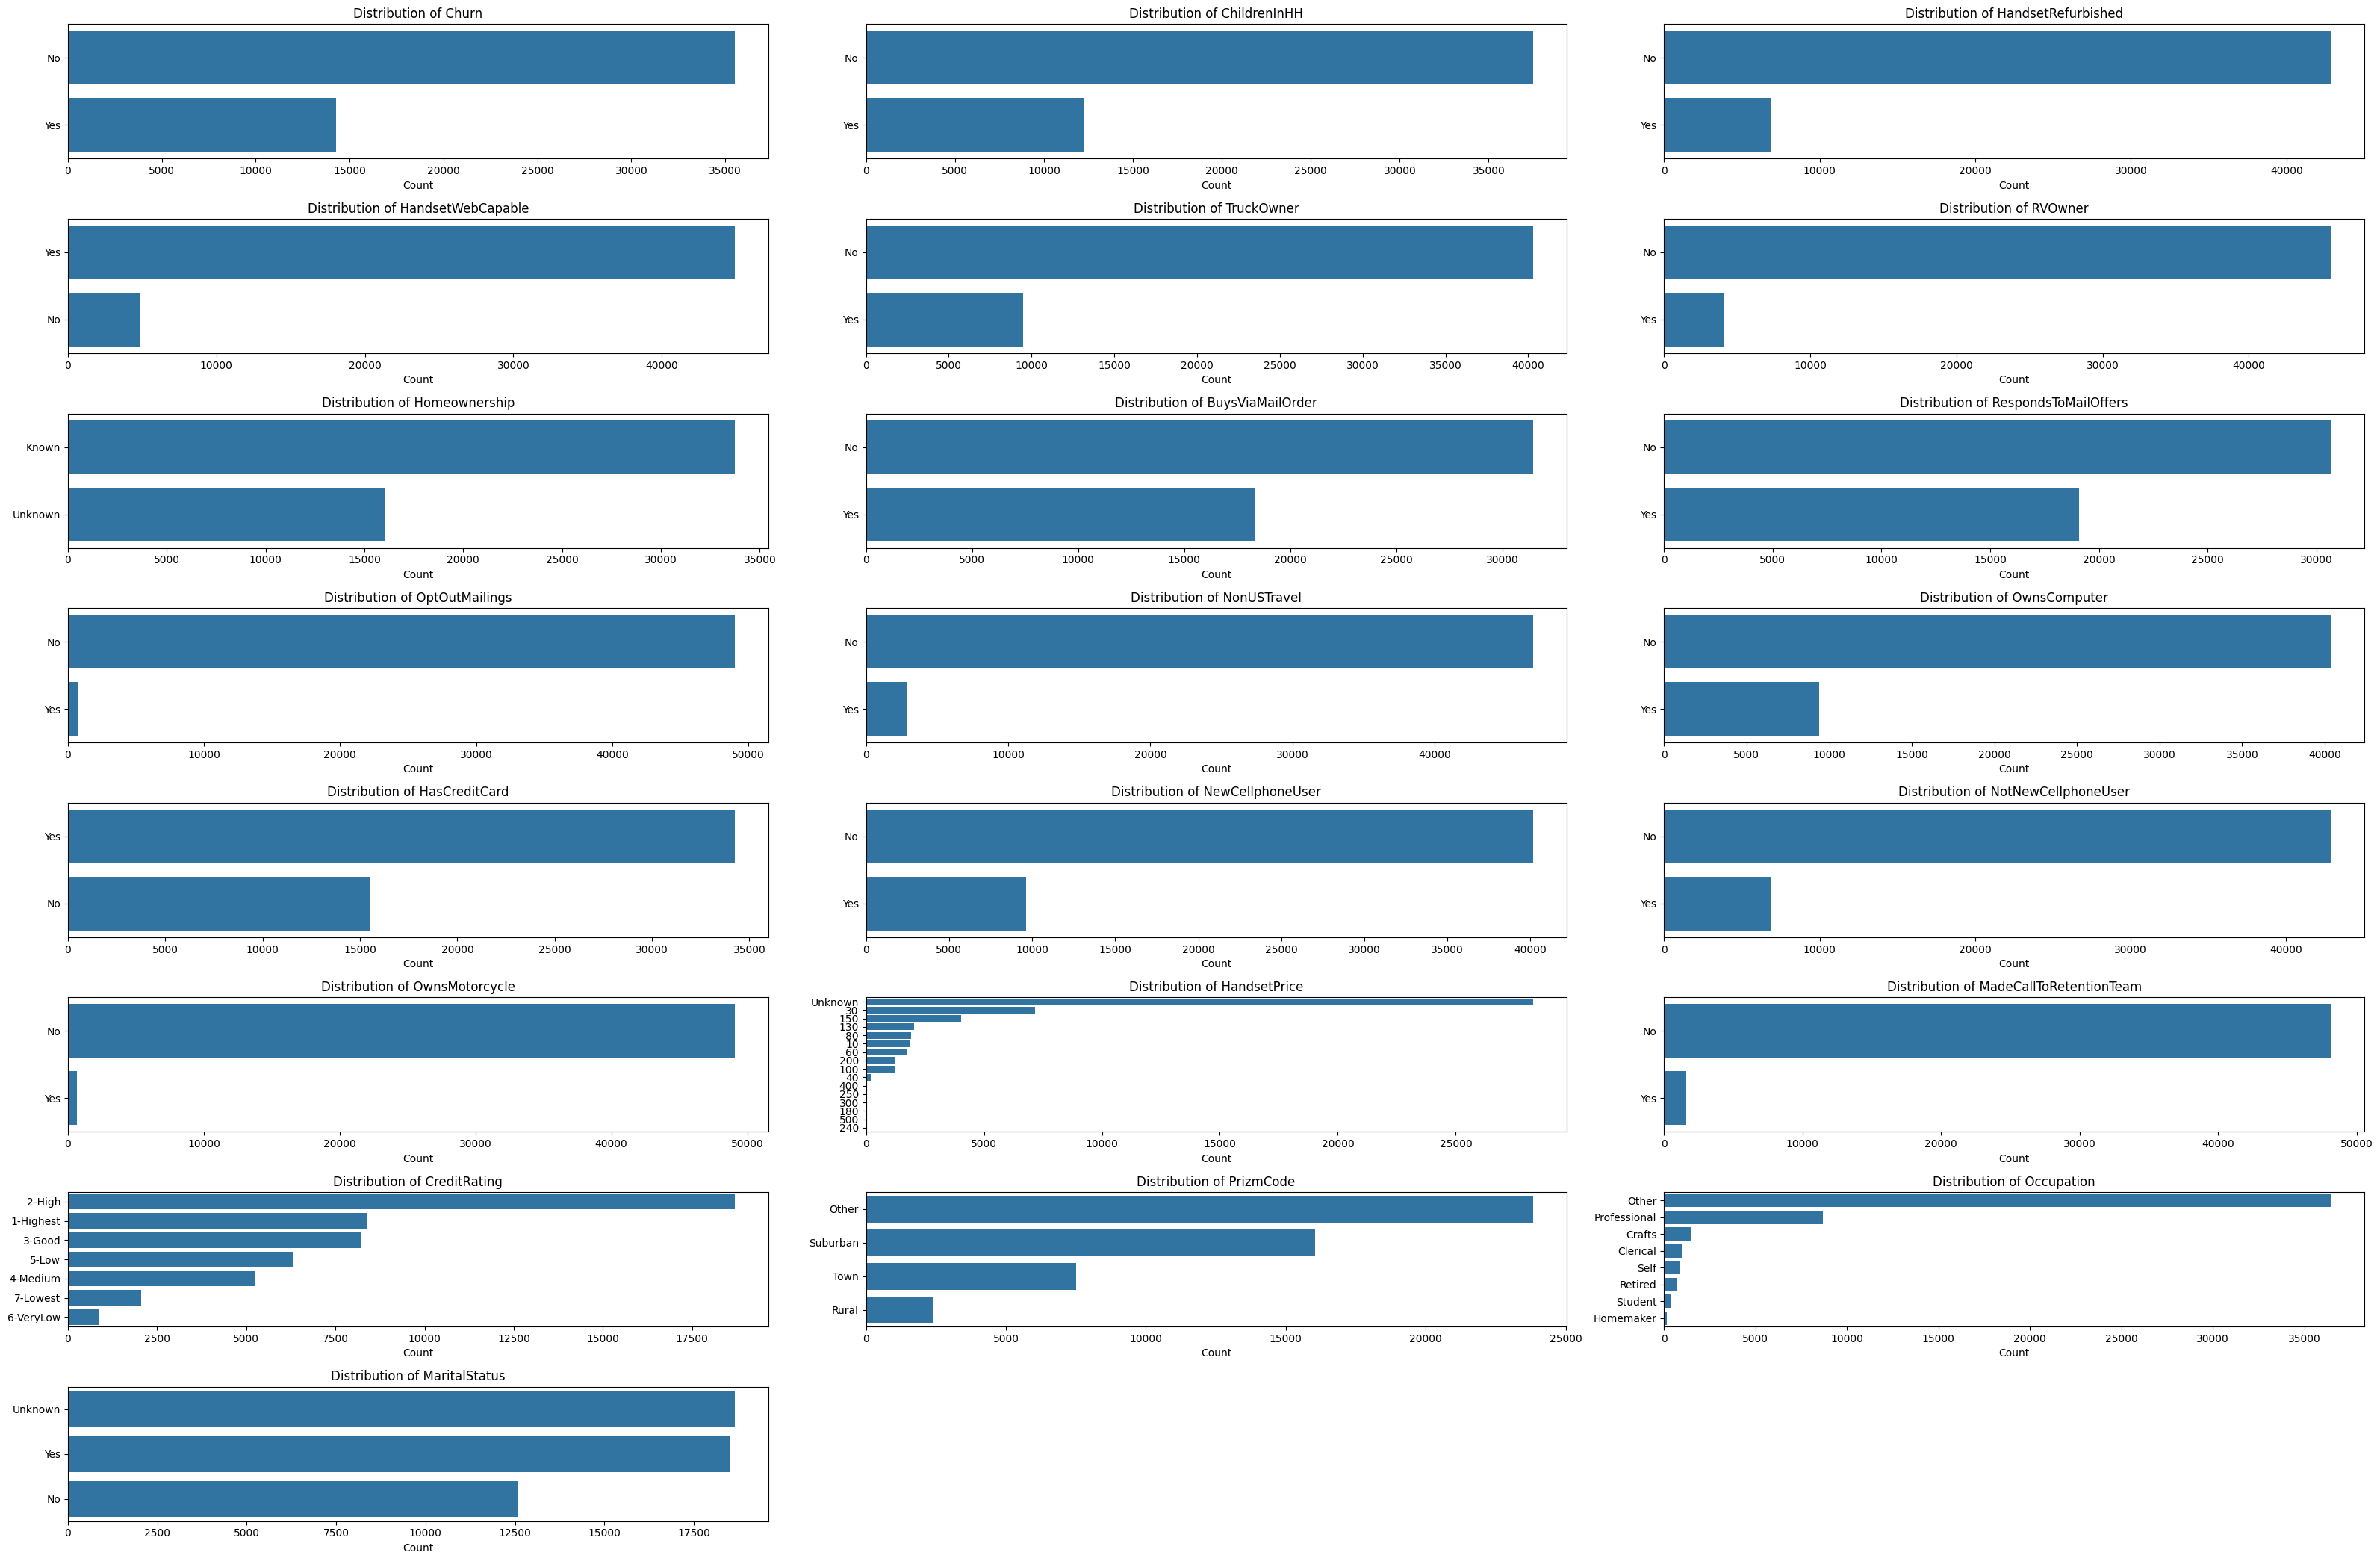

In [10]:
object_columns = df.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(8, 3, figsize=(32,21))
axes = axes.flatten()
for i, col in enumerate(object_columns):
    order = df[col].value_counts().index
    sns.countplot(y=col, data=df, order=order, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

for ax in axes[len(object_columns):]:
    ax.set_visible(False)

plt.tight_layout()
fig.savefig('../reports/figures/categorical_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
X_train = X_train.drop(columns=['HandsetPrice'])
X_test = X_test.drop(columns=['HandsetPrice'])

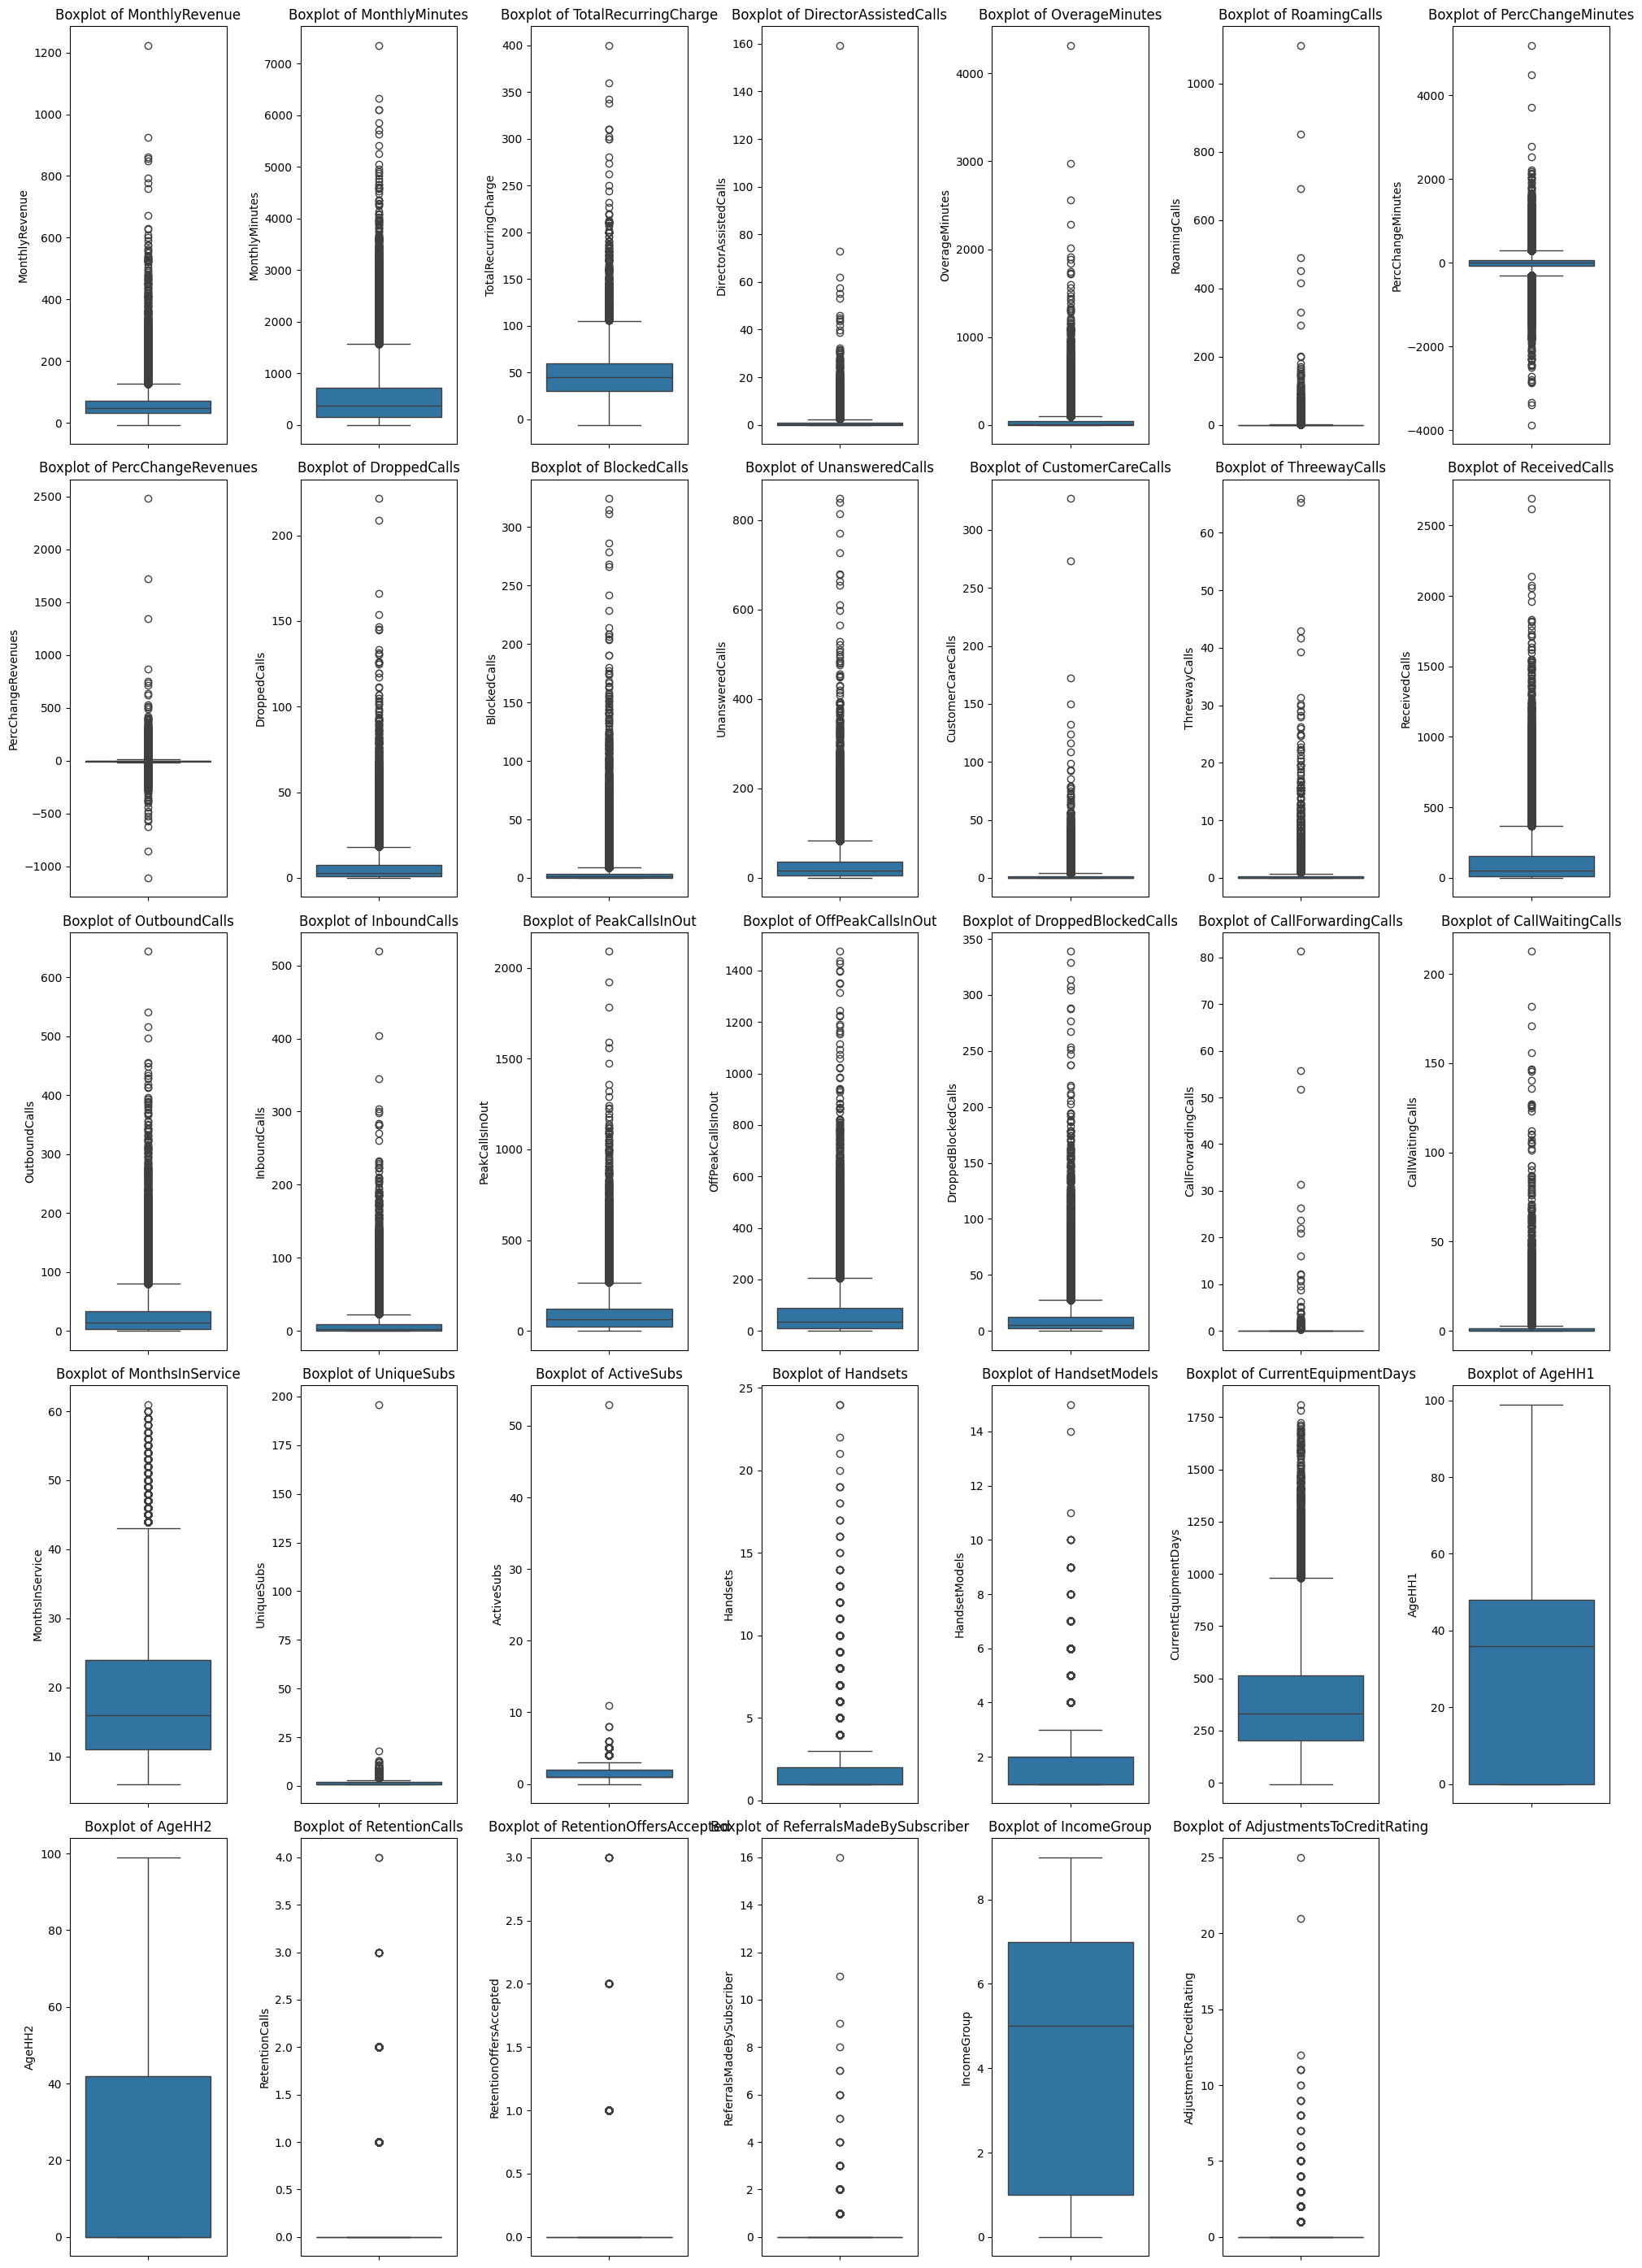

In [12]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
fig, axes = plt.subplots(5, 7, figsize=(20, 28))
axes = axes.flatten()
for idx, col in enumerate(numeric_columns):
    sns.boxplot(data=df, y=col, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col}')
for idx in range(len(numeric_columns), len(axes)):
    axes[idx].set_visible(False)
plt.tight_layout()
fig.savefig('../reports/figures/boxplots_numeric_features.png')
plt.show()

In [13]:
print(f'Number of rows where AgeHH1 is 0: {X_train.loc[X_train["AgeHH1"]==0].shape[0]}')
print(f'Number of rows where AgeHH2 is 0: {X_train.loc[X_train["AgeHH2"]==0].shape[0]}')

Number of rows where AgeHH1 is 0: 11750
Number of rows where AgeHH2 is 0: 21995


In [14]:
for col in ['AgeHH1', 'AgeHH2']:
    X_train[col] = X_train[col].replace(0, np.nan)
    X_test[col]  = X_test[col].replace(0, np.nan)

group_median_hh1 = X_train.groupby(['Occupation', 'MaritalStatus'])['AgeHH1'].median()
group_median_hh2 = X_train.groupby(['Occupation', 'MaritalStatus'])['AgeHH2'].median()

def group_impute(df, col, group_median):
    return df.apply(
        lambda row: group_median.get((row['Occupation'], row['MaritalStatus']), np.nan)
        if pd.isna(row[col]) else row[col],
        axis=1
    )
X_train['AgeHH1'] = group_impute(X_train, 'AgeHH1', group_median_hh1)
X_test['AgeHH1']  = group_impute(X_test,  'AgeHH1', group_median_hh1)

X_train['AgeHH2'] = group_impute(X_train, 'AgeHH2', group_median_hh2)
X_test['AgeHH2']  = group_impute(X_test,  'AgeHH2', group_median_hh2)

print(f'Number of rows where AgeHH1 is 0 after imputation in train set: {X_train.loc[X_train["AgeHH1"]==0].shape[0]}')
print(f'Number of rows where AgeHH2 is 0 after imputation in train set: {X_train.loc[X_train["AgeHH2"]==0].shape[0]}')
print(f'Number of rows where AgeHH1 is 0 after imputation in test set: {X_test.loc[X_test["AgeHH1"]==0].shape[0]}')
print(f'Number of rows where AgeHH2 is 0 after imputation in test set: {X_test.loc[X_test["AgeHH2"]==0].shape[0]}')

Number of rows where AgeHH1 is 0 after imputation in train set: 0
Number of rows where AgeHH2 is 0 after imputation in train set: 0
Number of rows where AgeHH1 is 0 after imputation in test set: 0
Number of rows where AgeHH2 is 0 after imputation in test set: 0


#### Handle outliers
+ The boxplots shows that that numerical features are highly skewed. For example, features like ```MonthlyRevenue``` has the bulk of the data lower than 100 but a few points reach nearly 1000, or ```ActiveSubs``` has the bulk of the data being near 0 but a few points reach very high maximums.

+ We handle outliers using the ```Winsorization method```, capping the lower and upper ```0.5%``` of the data 

In [15]:
lower_limit_percent = 0.005
upper_limit_percent = 0.005

for col in numeric_columns:
    if col in X_train.columns:
        lower = X_train[col].quantile(lower_limit_percent)
        upper = X_train[col].quantile(1 - upper_limit_percent)

        X_train[col] = X_train[col].clip(lower, upper)
        X_test[col]  = X_test[col].clip(lower, upper)

#### Encode variables

+ ***Binary columns***: The dataset has 16 binary columns. Binary columns has strings ‘Yes’ and ‘No’, which are converted to 1 and 0

+ ***Homeownership***: This binary column has strings 'Known' and 'Unknown', which are converted to 1 and 0

+ ```One-hot-encoding```: The other four non-binary categorical columns are transformed using on-hot-encoding. The resulting dataframe now has 68 columns

In [16]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
binary_categorical_columns = [col for col in categorical_columns if X_train[col].nunique() == 2]
for col in binary_categorical_columns:
    X_train[col] = X_train[col].map({'No': 0, 'Yes': 1, 'Known': 1, 'Unknown': 0})
    X_test[col]  = X_test[col].map({'No': 0, 'Yes': 1, 'Known': 1, 'Unknown': 0})

In [17]:
# Encoding non-binary categorical variables using OneHotEncoder with n-1 categories
non_binary_categorical_columns = [col for col in categorical_columns if X_train[col].nunique() > 2]
onehot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_encoded = onehot_encoder.fit_transform(X_train[non_binary_categorical_columns])
X_test_encoded  = onehot_encoder.transform(X_test[non_binary_categorical_columns])

# Create DataFrames for the encoded features
encoded_col_names = onehot_encoder.get_feature_names_out(non_binary_categorical_columns)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_col_names, index=X_train.index)
X_test_encoded_df  = pd.DataFrame(X_test_encoded, columns=encoded_col_names, index=X_test.index)

# Drop original non-binary categorical columns
X_train = X_train.drop(columns=non_binary_categorical_columns)
X_test  = X_test.drop(columns=non_binary_categorical_columns)

# Concatenate the encoded DataFrames back to the original DataFrames
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test  = pd.concat([X_test, X_test_encoded_df], axis=1)

#### Data normalization
+ The numerical data are on different scales. Z-score normalization is used to standardize the scaling of different features, which might help with model consistency and bias reduction


In [18]:
scaler = StandardScaler()

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

> ## 2. Feature Selection & Data Sampling

+ ```Mutual Information``` quantifies the statistical dependency between features and a target variable, measuring how much knowing a feature reduces uncertainty about the target

+ We use this technique to rank feature importance and choose the top ```30``` features to prevent the model from overfitting

+ The data's class unbalance (71% class 0 and 29% class 1) is handled using ```SMOTE sampling``` technique, which creates synthetic (artificial) data points for the minority class

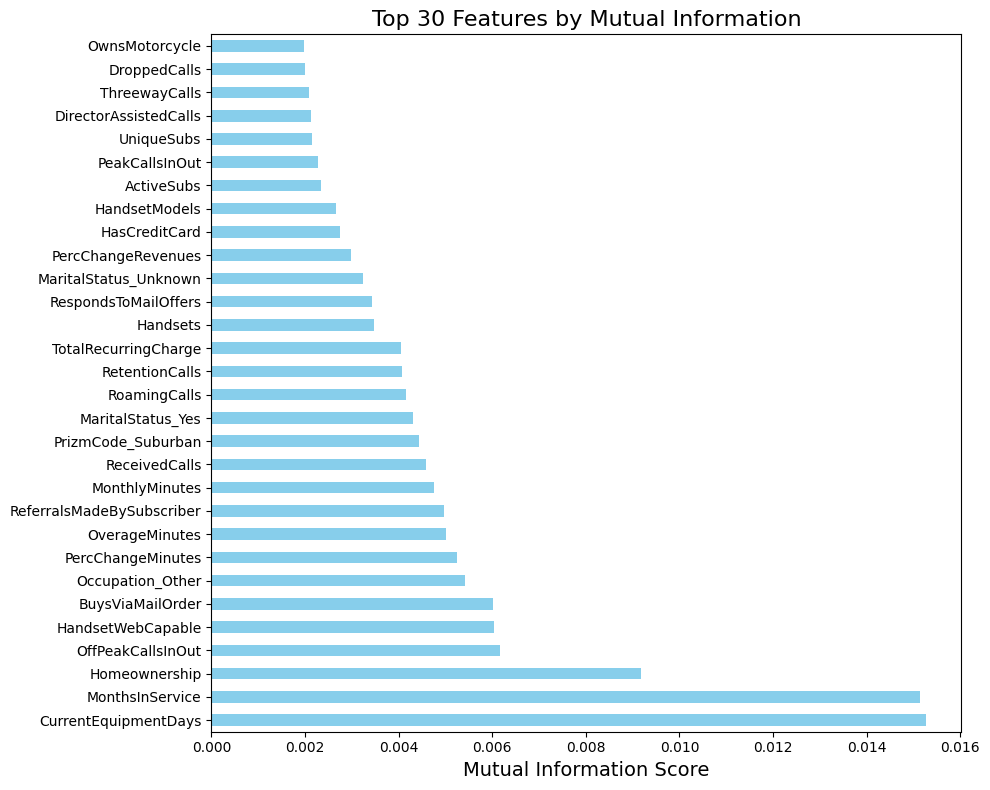

In [19]:
MI = mutual_info_classif(X_train, y_train, random_state=1)
k_feature = 30
top_k_features = pd.Series(MI, index=X_train.columns).sort_values(ascending=False).head(k_feature)
plt.figure(figsize=(10, 8))
top_k_features.plot.barh(color='skyblue')
plt.title(f'Top {k_feature} Features by Mutual Information', fontsize=16)
plt.xlabel('Mutual Information Score', fontsize=14)
plt.tight_layout()
plt.savefig(f'../reports/figures/top_{k_feature}_mi_features.png', dpi=300)
plt.show()
X_train = X_train[top_k_features.index]
X_test = X_test[top_k_features.index]

In [20]:
sampler = SMOTE(random_state=1, sampling_strategy=1.0)
X_train, y_train = sampler.fit_resample(X_train, y_train)

> ## 3. Model Training

#### ***Hyperparameter Tuning***

In [21]:
param_dist_rf = {
    "n_estimators": [300, 380, 450, 550],
    "max_depth": [None, 12, 14, 16, 18],
    "min_samples_split": [8, 10, 12, 15],
    "min_samples_leaf": [2, 3, 4, 6],
    "max_features": ["sqrt", 0.4, 0.6], 
    "bootstrap": [True],
    "class_weight": ["balanced_subsample"],
}

param_dist_lr = {
    "C": [0.01, 0.1, 1.0, 10.0, 50.0],
    "max_iter": [100, 200, 500, 1000],
    "l1_ratio": [0, 0.25, 0.5, 0.75, 1]
}

param_dist_knn = {
    "n_neighbors": [3,5,7,9],
    "weights": ["uniform", "distance"],
    "metric": ['euclidean', 'manhattan']
}

param_dist_nb = {
    "var_smoothing": np.logspace(0, -9, num=100)
}

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

rf_model  = RandomForestClassifier()
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression(solver = 'saga')
nb_model  = GaussianNB()

models = {
    "Random Forest":       {"model": rf_model,  "params": param_dist_rf},
    "Logistic Regression": {"model": lr_model,  "params": param_dist_lr},
    "KNN":                 {"model": knn_model, "params": param_dist_knn},
    "Naive Bayes":         {"model": nb_model,  "params": param_dist_nb},
}

def tune_model(model, param_dist, X_train, y_train, cv, n_iter=30, seed=1):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="roc_auc",
        cv=cv,
        random_state=seed,
        verbose=1,
        n_jobs=-1,
        refit=True,   # refits best model on full X_train at the end
    )
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_, search.best_score_

for model_name, mp in models.items():
    print(f"\nTuning hyperparameters for {model_name}...")

    best_model, best_params, best_cv_auc = tune_model(
        mp["model"], mp["params"], X_train, y_train, cv, n_iter=12, seed=40
    )

    # overwrite default model with tuned model + store metadata
    models[model_name]["model"] = best_model
    models[model_name]["best_params"] = best_params
    models[model_name]["cv_auc"] = best_cv_auc

    print(f"Best CV AUC: {best_cv_auc:.4f}")
    print(f"Best params: {best_params}")


Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best CV AUC: 0.8832
Best params: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.4, 'max_depth': None, 'class_weight': 'balanced_subsample', 'bootstrap': True}

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV AUC: 0.6184
Best params: {'max_iter': 500, 'l1_ratio': 0.25, 'C': 50.0}

Tuning hyperparameters for KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV AUC: 0.8520
Best params: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}

Tuning hyperparameters for Naive Bayes...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV AUC: 0.5911
Best params: {'var_smoothing': np.float64(0.0002848035868435802)}


#### ***Compare different models' performance***

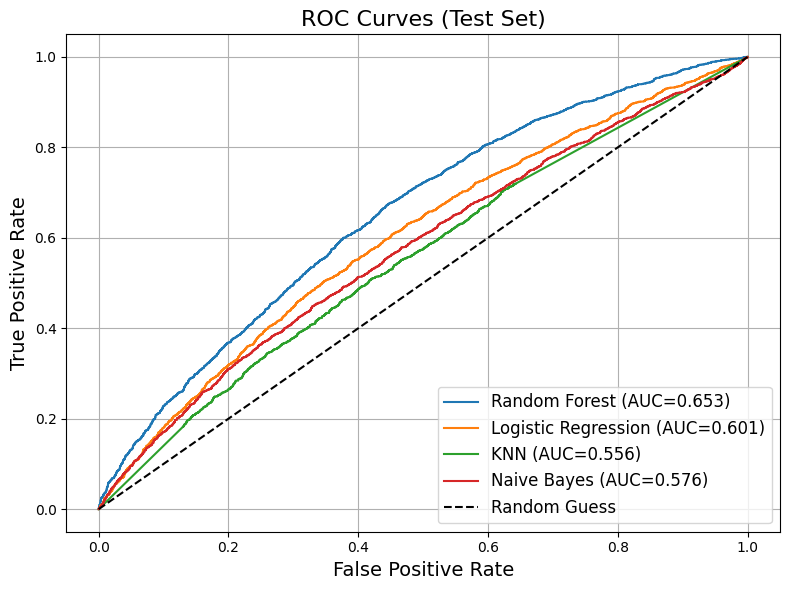

In [23]:
plt.figure(figsize=(8, 6))

for name, mp in models.items():
    scores = mp["model"].predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")


plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.title("ROC Curves (Test Set)", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('../reports/figures/roc_curves_models.png', dpi=300, bbox_inches='tight')
plt.show()

> ## 4. Optimizing model threshold

### ***Economic Model***

While machine learning models are typically optimized using statistical metrics such as ROC-AUC, deploying a model in practice requires selecting a decision threshold that aligns with business objectives. In the context of customer churn, the optimal threshold should maximize expected profit, not just classification accuracy

To bridge the gap, we formulate a simple expected-value-based model that translates model performance ```(TPR, FPR)``` into ```monetary outcomes```

We assume churners are lost unless successfully retained via the incentive, and based on the dataset and industry benchmarks, we assume:

+ Cost of offering retention incentives to one customer: ```C = $10```

+ Average customer life time value: ```R = $180```

+ Natural probability of churn: ```29%``` (drawing from dataset)

+ Natural probability of not churn: ```71%``` (drawing from dataset)

+ Incentives effectiveness (Probability that an incentives offer successfully prevent a customer from churning): ```q = 18%```

+ Total number of customers: ```N = 300,000```

+ Predicted churn probability of a customer (Random forest model output): ```p```


### ***Decision Baselines***

> ### 1. No retention incentives

The firm retains only non-churning customers and loses 29% of customers due to natural churn

$$ EV = 71\% . N . R = 38,340,000 $$

> ### 2. Incentives to all customers

High cost with limited efficiency, leading to lower expected value than not offering any incentives

$$ EV = (-C) . N + R . (71\% + 29\% . q) . N = 38,158,800 $$

> ### 3. Decision based on ML model output

Offer incentives if model predict positive, no if model predict negative

$$ TP = True Positive = True Positive Rate * N * 29% $$

$$ FP = False Positive = False Positive Rate * N * 71% $$

$$ EV = (-C) . (TP + FP) +  R . (71\% . N + TP . q ) $$

$$ EV = 38,340,000 + 1,948,800 TPR - 2,130,000 FPR $$


+ Best strategy is to choose model threshold t that maximize: TPR - 2,130,000/1,948,800 FPR or ```TPR - 1.093 FPR```

+ Applying this criterion to the ROC curve yields an optimal threshold of t = 0.257, resulting in an incremental expected value of ```$393,559``` relative to the no-intervention baseline

+ The economically optimal threshold ```prioritizes recall over precision```, reflecting the fact that the cost of losing a customer (Type II error) is substantially higher than the cost of offering an unnecessary incentive (Type I error)

### ***Final threshold selection & best model's performance***

Best threshold: 0.38391783478728847
TPR: 0.6002805049088359
FPR: 0.37706456456456455
Objective function (TPR - 1.0929802955665024*FPR): 0.1881563656834036
Positive value added: $366679.125443817


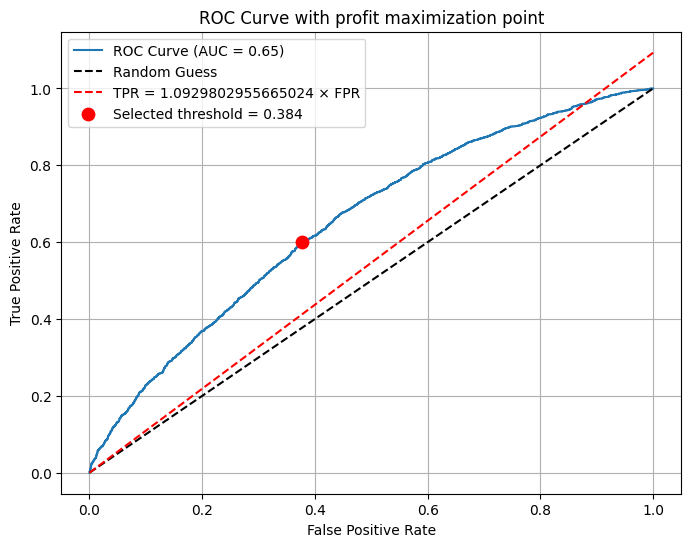

In [24]:
best_model = models["Random Forest"]["model"]
y_scores = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
k = 2130000 / 1948800
score = tpr - k * fpr
best_idx = np.argmax(score)

best_threshold = thresholds[best_idx]
best_tpr = tpr[best_idx]
best_fpr = fpr[best_idx]
best_score = score[best_idx]

print("Best threshold:", best_threshold)
print("TPR:", best_tpr)
print("FPR:", best_fpr)
print(f"Objective function (TPR - {k}*FPR):", best_score)
print("Positive value added:", f'${1948800 * best_tpr - 2130000 * best_fpr}')

plt.figure(figsize=(8, 6))

# ROC curve
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Constraint line: TPR = k * FPR
x = np.linspace(0, 1, 200)
plt.plot(x, k * x, 'r--', label=f'TPR = {k} × FPR')

# Highlight best point
plt.scatter(best_fpr, best_tpr,
            color='red', s=80, zorder=5,
            label=f'Selected threshold = {best_threshold:.3f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with profit maximization point')
plt.legend()
plt.grid(True)
plt.savefig('../reports/figures/roc_curve_point_of_profit_maximization.png', dpi=300, bbox_inches='tight')
plt.show()

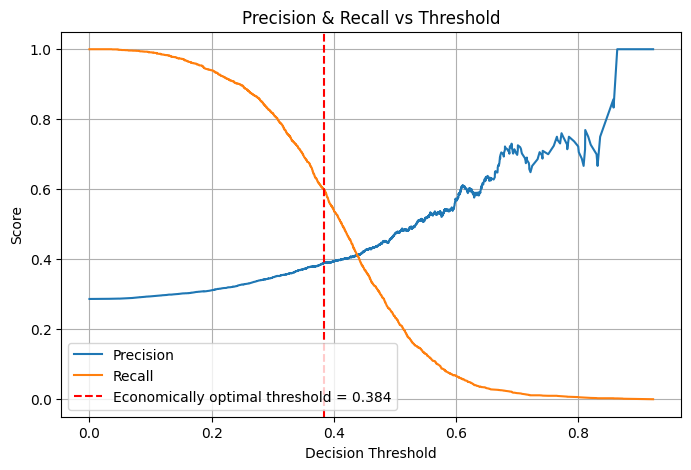

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
thresholds_full = np.concatenate(([0], thresholds))

plt.figure(figsize=(8, 5))
plt.plot(thresholds_full, precision, label="Precision")
plt.plot(thresholds_full, recall, label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.axvline(
    x=best_threshold,
    color='red',
    linestyle='--',
    label=f'Economically optimal threshold = {best_threshold:.3f}'
)
plt.legend()
plt.savefig('../reports/figures/precision_recall_vs_threshold.png', dpi=300, bbox_inches='tight')
plt.show()

[[3319 2009]
 [ 855 1284]]


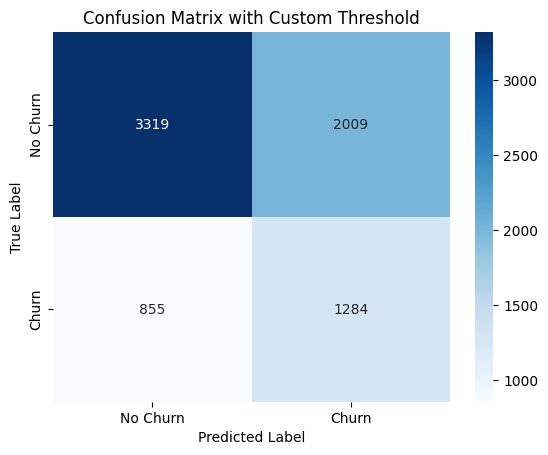

In [26]:
best_threshold
y_test_pred = (y_scores >= best_threshold).astype(int)
pd.DataFrame({'y_test_pred_custom': y_test_pred})
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Custom Threshold')
plt.show()

In [27]:
print((classification_report(y_test,y_test_pred)))

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      5328
           1       0.39      0.60      0.47      2139

    accuracy                           0.62      7467
   macro avg       0.59      0.61      0.59      7467
weighted avg       0.68      0.62      0.63      7467

